BDS^3
=====

## Вступ до аналізу біологічних зобраржень на Python
---

- Завантаження зображень
- Структура зображень в Python, масиви
- Відображення картинок matplotlib та кольорові маски
- Гістограма зображення
- Логічна індексація зображень та маски
- Пошук оптимального порогу для побудови маски
- Фільтрація маски, морфологічні оператори
- Сегментація маски та отримання лейблів окремих об'єктів на зображенні
- Завантажння серії зображень
- Побудова маски та прикладання маски до серії зображень
- Побудова профілю інтенсивності регіону маски за серією зображень

In [32]:
import numpy as np
import skimage
import matplotlib.pyplot as plt

# Аналіз окремого зображення
---

### Завантаження зображень

In [33]:
image = skimage.io.imread('data/cell_image.tif')

In [34]:
image.shape

(256, 256)

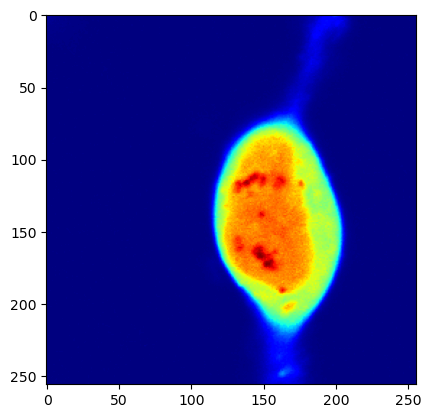

In [35]:
plt.imshow(image, cmap='jet')

In [36]:
image.max()

3494

### Властивості масивів

In [37]:
demo_arr = np.asarray([0, 1, 4, 6, 2])
demo_arr

array([0, 1, 4, 6, 2])

In [38]:
demo_list = [0, 1, 4, 6, 2]
demo_list

[0, 1, 4, 6, 2]

In [39]:
demo_list[2] > 1

True

In [40]:
demo_arr > 1

array([False, False,  True,  True,  True])

### Побудова масок та гістонрами зображення

In [41]:
simple_mask = image > 500

In [42]:
print(simple_mask.shape)
print(image.shape)

(256, 256)
(256, 256)


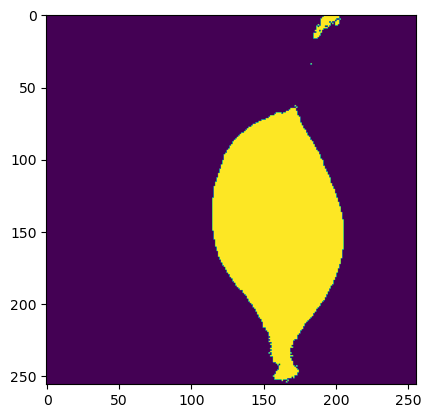

In [43]:
plt.imshow(simple_mask)

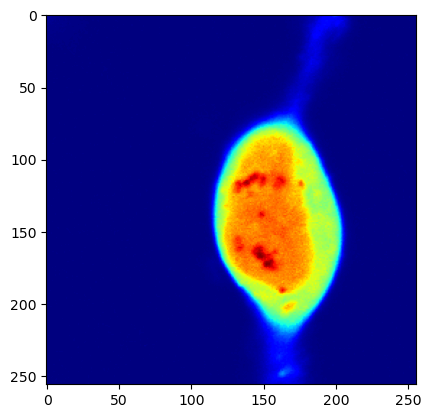

In [44]:
plt.imshow(image, cmap='jet')

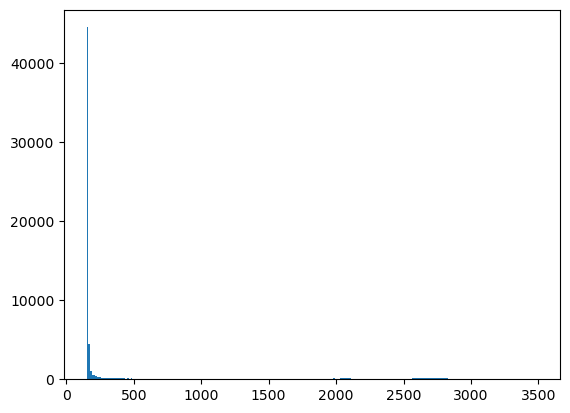

In [45]:
plt.hist(image.ravel(), bins=256)
plt.show()

### Сегментація зображення з використання мульти-Отсу

In [46]:
th_otsu = skimage.filters.threshold_otsu(image)
th_otsu

1277

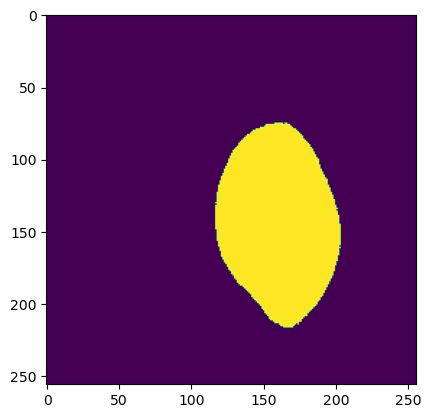

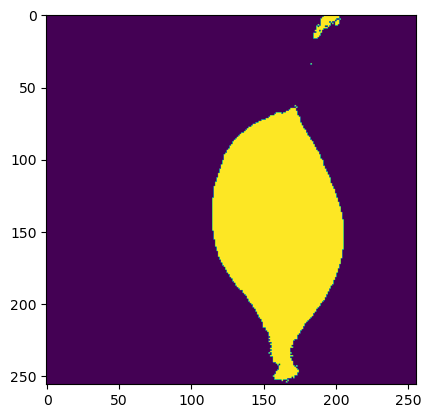

In [47]:
otsu_mask = image > th_otsu
plt.imshow(otsu_mask)
plt.show()

plt.imshow(simple_mask)
plt.show()

In [48]:
multi_otsu_th = skimage.filters.threshold_multiotsu(image)
multi_otsu_th

array([1012, 2264])

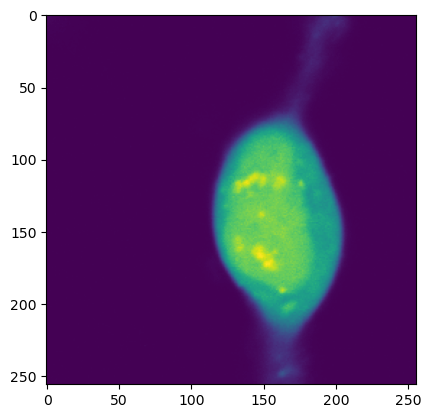

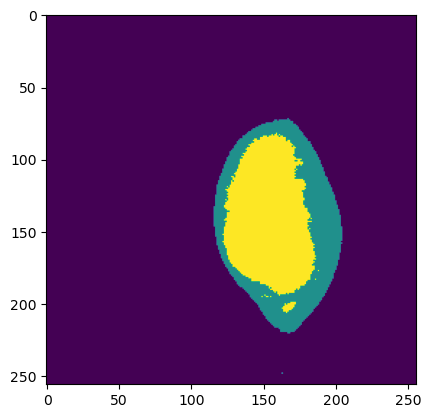

In [49]:
cell_segments = np.digitize(image, bins=multi_otsu_th)

plt.imshow(image)
plt.show()
plt.imshow(cell_segments)
plt.show()

### Фільтр Гауса

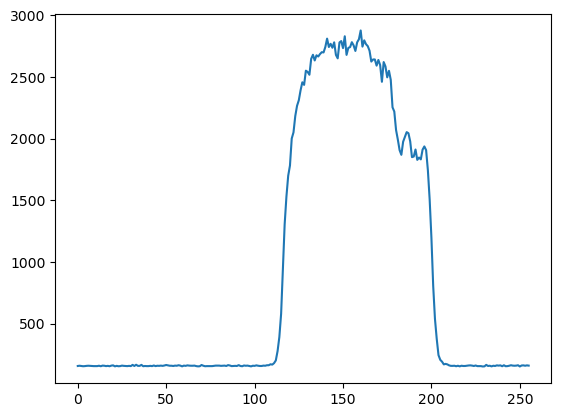

In [50]:
plt.plot(image[130, :])

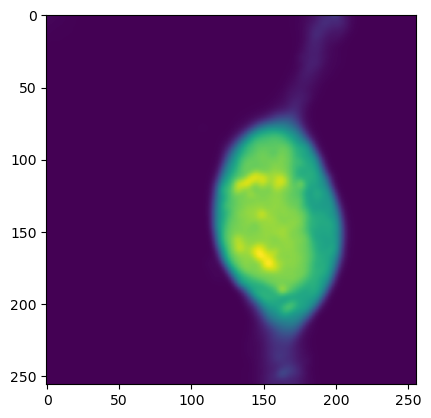

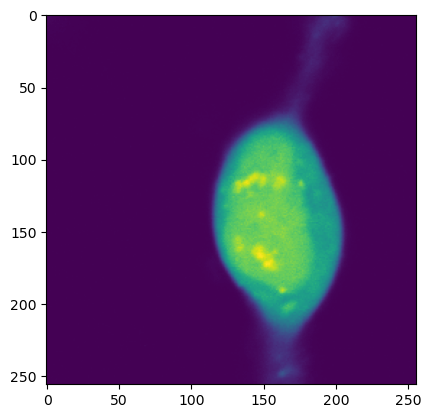

In [51]:
image_filtered = skimage.filters.gaussian(image, sigma=2)

plt.imshow(image_filtered)
plt.show()

plt.imshow(image)
plt.show()

### Морфологічні оператори

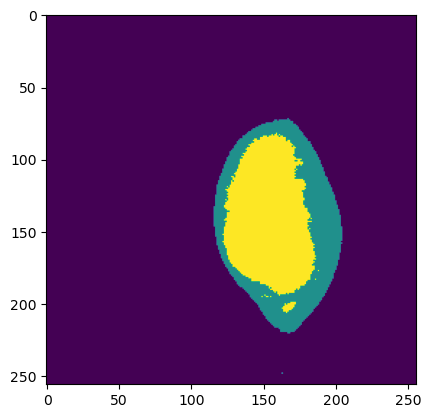

In [52]:
plt.imshow(cell_segments)
plt.show()

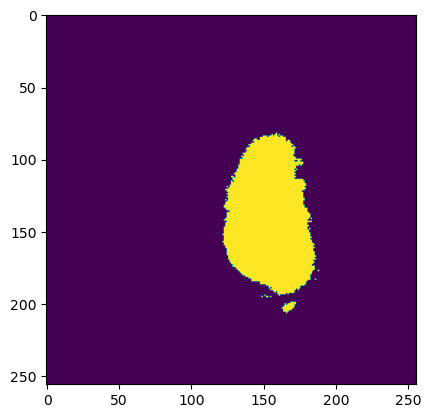

In [53]:
nucl_mask = ~(cell_segments < 2)

plt.imshow(nucl_mask)
plt.show()

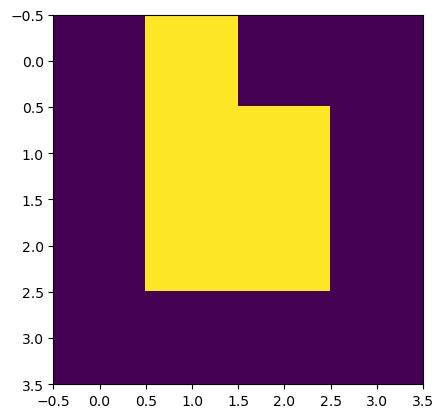

In [54]:
demo_arr = [[0, 1, 0, 0],
            [0, 1, 1, 0],
            [0, 1, 1, 0],
            [0, 0, 0, 0]]

plt.imshow(demo_arr)

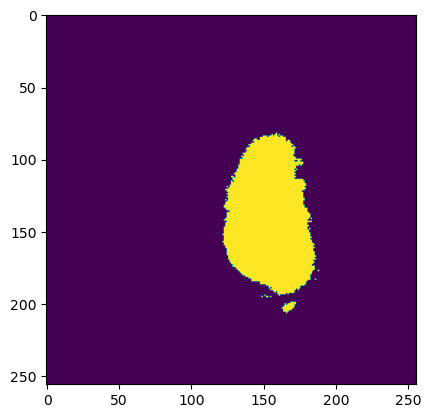

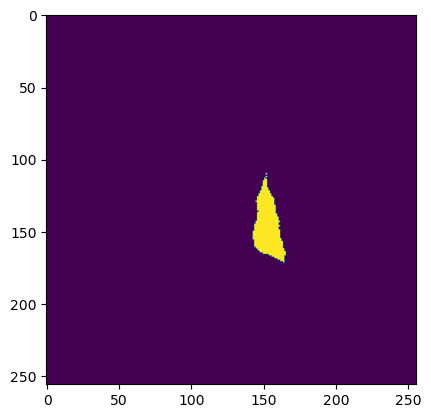

In [55]:
foot = [[1,1,1],
        [1,1,1],
        [1,1,1]]
disk_foot = skimage.morphology.disk(20)
nucl_erosion = skimage.morphology.erosion(nucl_mask, footprint=disk_foot)

plt.imshow(nucl_mask)
plt.show()

plt.imshow(nucl_erosion)
plt.show()

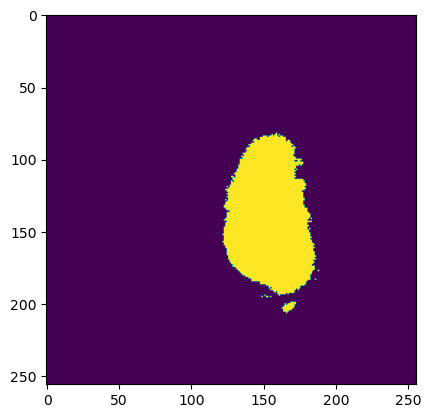

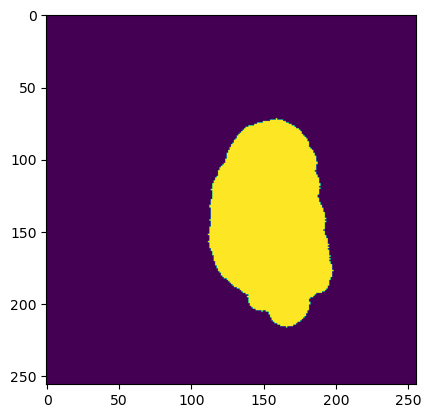

In [56]:
disk_foot_d = skimage.morphology.disk(10)
nucl_dilation = skimage.morphology.dilation(nucl_mask, footprint=disk_foot_d)

plt.imshow(nucl_mask)
plt.show()

plt.imshow(nucl_dilation)
plt.show()

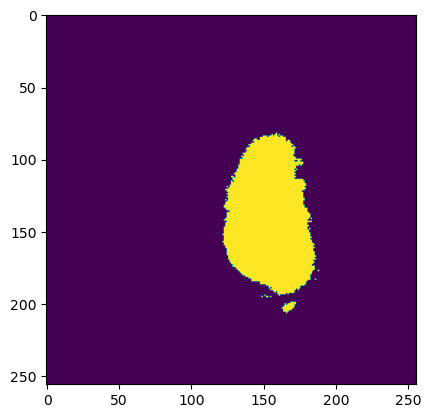

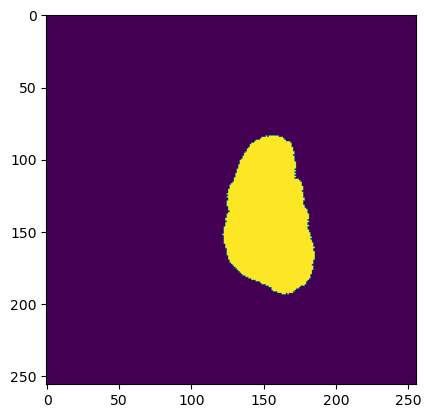

In [57]:
foot_e_d = skimage.morphology.disk(5)

eroded_mask = skimage.morphology.erosion(nucl_mask, footprint=foot_e_d)
fin_mask = skimage.morphology.dilation(eroded_mask, footprint=foot_e_d) 

plt.imshow(nucl_mask)
plt.show()

plt.imshow(fin_mask)
plt.show()

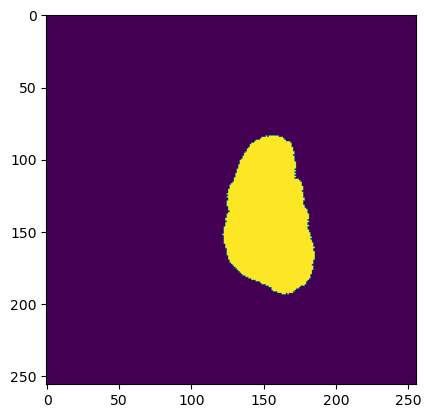

In [58]:
op_mask = skimage.morphology.opening(nucl_mask, footprint=foot_e_d)

plt.imshow(op_mask)

# Аналіз серії зображень
---

In [59]:
image_series = skimage.io.imread('data/cell_series.tif')
image_series.shape

(30, 256, 256)

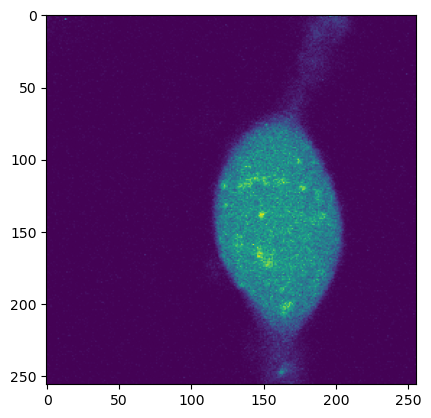

In [60]:
plt.imshow(image_series[0])

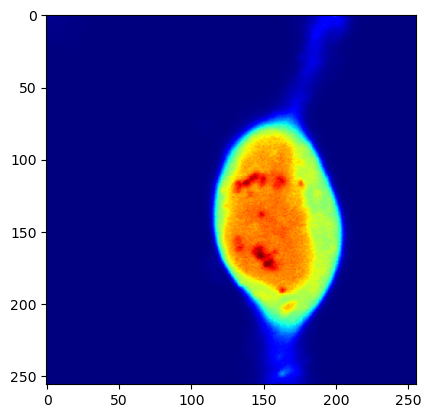

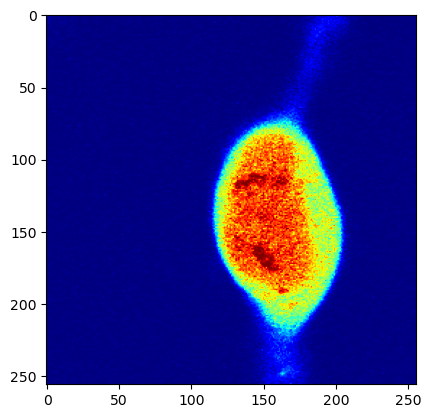

In [61]:
ctrl_img = np.mean(image_series, axis=0)

plt.imshow(ctrl_img, cmap='jet')
plt.show()

plt.imshow(image_series[15], cmap='jet')
plt.show()

In [62]:
ctrl_img_blure = skimage.filters.gaussian(ctrl_img, sigma=1.5)      # розмиття картинки
th_multi = skimage.filters.threshold_multiotsu(ctrl_img_blure)      # обчислення порогів мульти Отсу
ctrl_img_segmentation = np.digitize(ctrl_img_blure, bins=th_multi)  # сегментація картинки

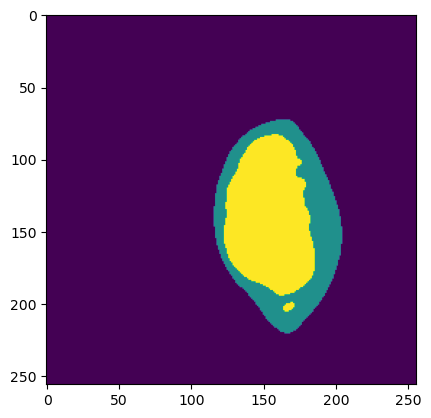

In [63]:
plt.imshow(ctrl_img_segmentation)

Побудова масок елементів клітини

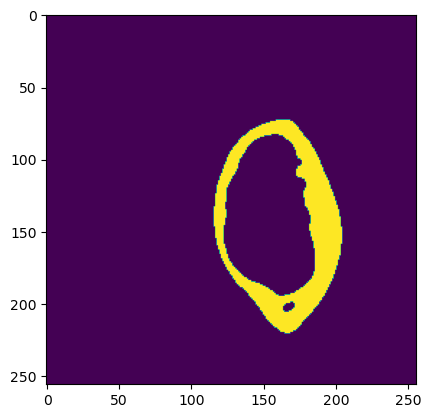

In [64]:
cytoplasm_mask = ctrl_img_segmentation == 1
plt.imshow(cytoplasm_mask)

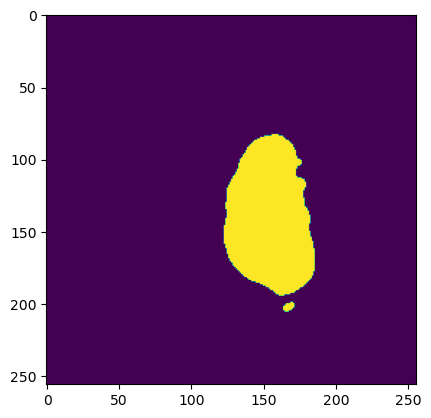

In [65]:
nucleus_mask = ctrl_img_segmentation == 2
plt.imshow(nucleus_mask)

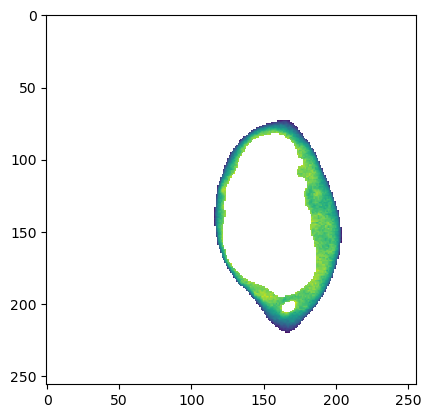

In [66]:
from numpy import ma

masked_cytoplasm = ma.masked_where(~cytoplasm_mask, ctrl_img)

plt.imshow(masked_cytoplasm)

In [67]:
np.mean(masked_cytoplasm)

1832.189725297253

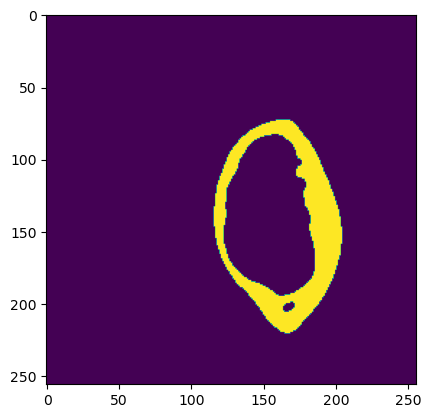

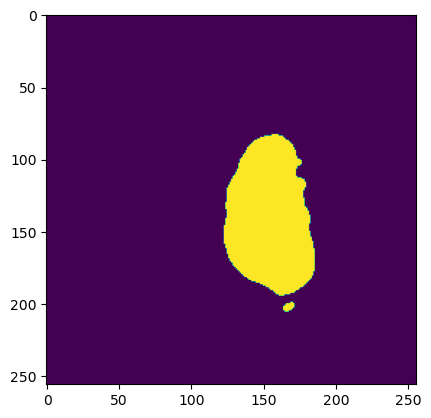

In [68]:
plt.imshow(cytoplasm_mask)
plt.show()

plt.imshow(nucleus_mask)
plt.show()

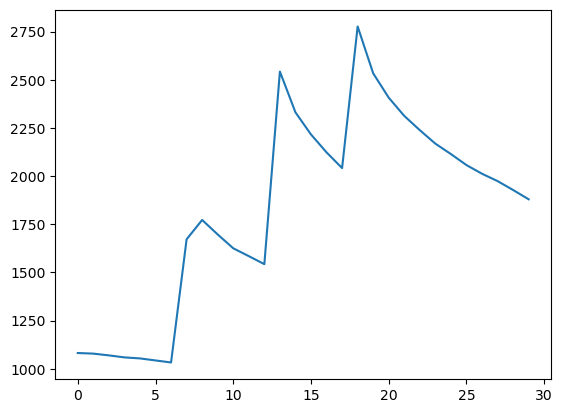

In [69]:
cytoplasm_int_profile = []

for single_frame in image_series:
    masked_frame = ma.masked_where(~cytoplasm_mask, single_frame)
    frame_mean = np.mean(masked_frame)
    cytoplasm_int_profile.append(frame_mean)

plt.plot(cytoplasm_int_profile)

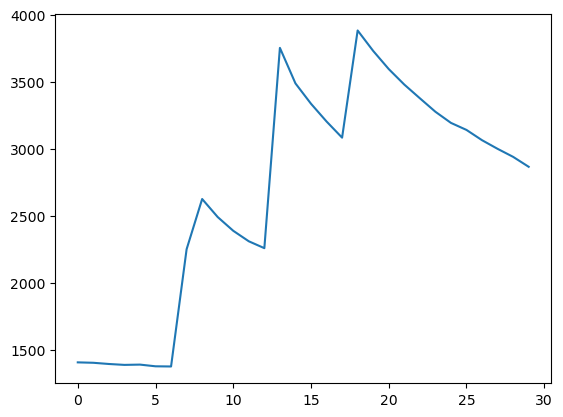

In [70]:
nucleus_int_profile = []

for single_frame in image_series:
    masked_frame = ma.masked_where(~nucleus_mask, single_frame)
    frame_mean = np.mean(masked_frame)
    nucleus_int_profile.append(frame_mean)

plt.plot(nucleus_int_profile)

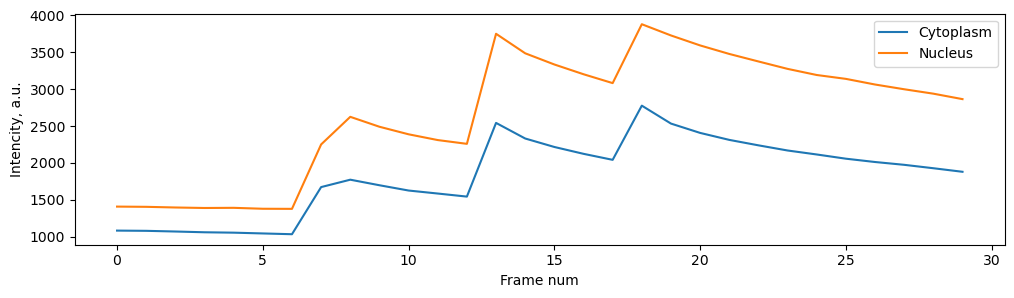

In [71]:
plt.figure(figsize=[12, 3])
plt.plot(cytoplasm_int_profile, label='Cytoplasm')
plt.plot(nucleus_int_profile, label='Nucleus')

plt.xlabel('Frame num')
plt.ylabel('Intencity, a.u.')
plt.legend()


In [72]:
demo_arr = np.asarray(demo_list)

demo_list_new = [list_element + 1 for list_element in demo_list]

print(demo_list)
print(demo_list_new)



[0, 1, 4, 6, 2]
[1, 2, 5, 7, 3]


In [73]:
import pandas as pd

In [80]:
frame_num_list = list(range(1, 31))

In [85]:
demo_dict = {1:'a', 'b':2}

In [87]:
dict_for_df = {'frame_num':frame_num_list,
               'nucl_int': nucleus_int_profile,
               'cyto_int':cytoplasm_int_profile}

In [88]:
int_profiles_df = pd.DataFrame(dict_for_df)
int_profiles_df

,frame_num,nucl_int,cyto_int
0,1,1407.170241,1081.523985
1,2,1404.066591,1078.390898
2,3,1395.068284,1069.191390
3,4,1388.319037,1058.775646
4,5,1390.488149,1053.505289
5,6,1377.843868,1042.904305
6,7,1376.507148,1032.372940
7,8,2250.642024,1671.838376
8,9,2625.098570,1772.226322
9,10,2490.588224,1696.872817


# Детекція багатаьох об'єктів на зображені
---

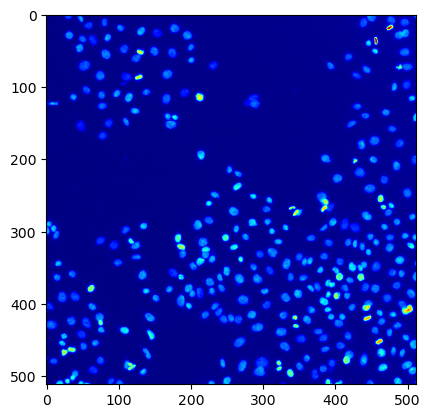

In [92]:
cells_image = skimage.data.human_mitosis()
plt.imshow(cells_image, cmap='jet')

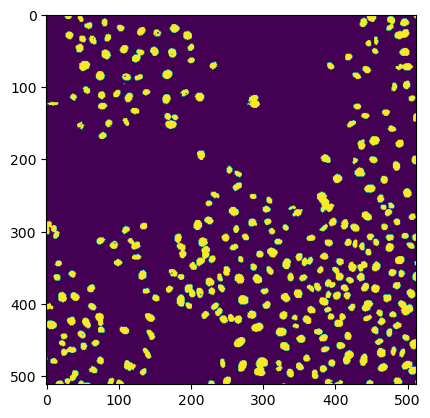

In [94]:
cells_mask = cells_image > skimage.filters.threshold_otsu(cells_image)
plt.imshow(cells_mask)

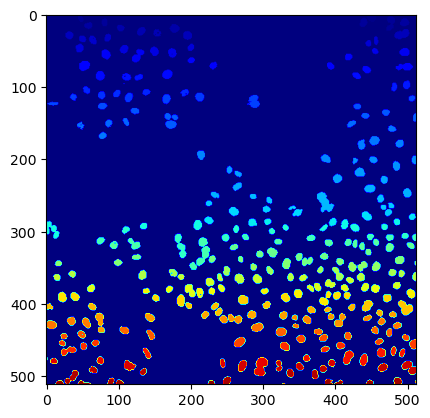

In [95]:
cells_labels = skimage.morphology.label(cells_mask)
plt.imshow(cells_labels, cmap='jet')

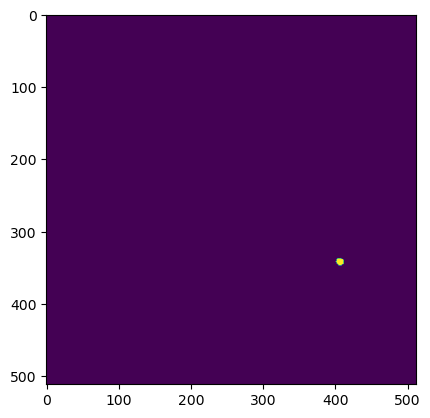

In [96]:
plt.imshow(cells_labels == 150)